See https://stackoverflow.com/questions/48674558/how-to-implement-automatic-model-determination-and-two-state-model-fitting-in-py

SIGMA:  [0.99067178 0.97197128 0.95664858 0.94349452 0.90848502]
m1= -1.633e-03 n1= 2.041e+01 m2= -6.540e-04 n2= 1.920e+01
First guess Tex cold 265.9
First guess Tex hot 664.0
ma1= -2.219e-03 na1= 2.062e+01 ma2= -6.473e-04 na2= 1.917e+01
Fit Tex cold 195.7
Fit Tex hot 670.9


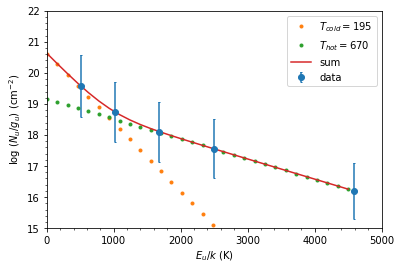

In [17]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator
import math
%matplotlib inline

def partfun(x):
    return 0.025*x/(1-np.exp(-6000.0/x))

def x_exp(x,m1,n1,m2,n2):
    return n1*partfun(x)*np.exp(x*m1)+n2*partfun(x)*np.exp(x*m2)

def one_lin(x,m1,n1):
    return m1*x+n1

#custom fit function  
def two_lin(x, m1, n1, m2, n2):
    #second slope steeper (because negative slopes)
    return np.max([m1 * x + n1, m2 * x + n2], axis = 0)
    #first slope steeper than second slope
    #    return np.min([m1 * x + n1, m2 * x + n2], axis = 0)

def x_lin(x, m1, n1, m2, n2):
    zz1 = 10**(x*m1+n1)
    zz2 = 10**(x*m2+n2)
    retval = np.log10(zz1+zz2)
    return retval

def x2_lin(x, m1, n1, m2, n2):
    return x*m1 + n1 + x*m2 +n2

#x/y data points
if False:
    x = np.asarray([0, 1, 2,  3,  4,  5,  6,  7,  8,  9,  10])
    y = np.asarray([2, 4, 8, 12, 14, 18, 20, 21, 22, 23,  24])
    #initial guess for a steep rising and plateau phase
    start_values = [3, 0, 0, 3]
    #curve fitting
    fit_param, pcov = curve_fit(two_lin, x, y, p0 = start_values)
else:
    x = np.array([509.8,1015.0,1682.0,2504.0,4586.0])
    y = np.array([19.575,18.75,18.1,17.56,16.2])
    sigma = np.log10(0.5*y)
    print("SIGMA: ",sigma)
    fit_param, pcov = curve_fit(two_lin, x, y,sigma=sigma)
#output of slope/intercept for both parts
m1, n1, m2, n2 = fit_param
print("m1= %.3e n1= %.3e m2= %.3e n2= %.3e"%(m1, n1, m2, n2))
tcold=-math.log10(math.e)/m1
thot=-math.log10(math.e)/m2
print("First guess Tex cold %.1f"%tcold)
print("First guess Tex hot %.1f"%thot)
#calculating sum of squared residuals as parameter for fit quality
r = y - two_lin(x, *fit_param)
#print("resid ",np.sum(np.square(r)))

#point, where the parts intersect 
if m1 != m2:
    x_intersect = (n2 - n1) / (m1 - m2)
#    print(x_intersect)
else:
    print("did not find two linear components")
    
#bounds=(np.array([-1,18.0,-1,18.0]),np.array([0,25.0,0,25.0]))
#print("BOUNDS ",bounds)
fit_par2,pcov2 = curve_fit(x_lin,x,y,p0=fit_param,sigma=sigma)#,method='trf',bounds=bounds)
ma1, na1, ma2, na2 = fit_par2
print("ma1= %.3e na1= %.3e ma2= %.3e na2= %.3e"%(ma1, na1, ma2, na2))
tcolda=-math.log10(math.e)/ma1
thota=-math.log10(math.e)/ma2
print("Fit Tex cold %.1f"%tcolda)
print("Fit Tex hot %.1f"%thota)
r = y - x_lin(x, *fit_par2)
#print("resid2 ",np.sum(np.square(r)))

if False:
    yy = 10**y
    ss = 0.5*yy
    p0 = [m1,10**n1,m2,10**n2]
    fit_par3,pcov3, = curve_fit(x_exp,x,y,sigma=ss)
    ma3, na3, ma4, na4 = fit_par3
    print("ma3= %.3e na3= %.3e ma4= %.3e na4= %.3e"%(ma3, na3, ma4, na4))
    tcoldaa=-math.log10(math.e)/ma3
    thotaa=-math.log10(math.e)/ma4
    print("Tex cold exp %.1f"%tcoldaa)
    print("Tex hot exp %.1f"%thotaa)

#plot data and fit function
x_fit = np.linspace(1, 4500, 30)  
#plt.plot(x, y, 'o', label='data')

plt.errorbar(x, y, yerr=sigma, fmt="o", capsize=1,label='data')
#plt.plot(x_fit, two_lin(x_fit, *fit_param), '--', label='fit')
#plt.plot(x_fit,one_lin(x_fit, m1,n1),'.',label="$T_{cold}=%d$"%tcold)
#plt.plot(x_fit,one_lin(x_fit, m2,n2),'.',label="$T_{hot}=%d$"%thot)
plt.plot(x_fit,one_lin(x_fit, ma1,na1),'.',label="$T_{cold}=%d$"%tcolda)
plt.plot(x_fit,one_lin(x_fit, ma2,na2),'.',label="$T_{hot}=%d$"%thota)
#plt.plot(x_fit,x_lin(x_fit,*fit_par2),label='sum')
plt.plot(x_fit,x_lin(x_fit,*fit_par2),label="sum")
#plt.plot(x_fit,x2_lin(x_fit,*fit_param),label='sum2')
if False: plt.axis([-2, 12, 0, 22])
else: 
    plt.axis([0,5000,15,22])
    plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
    plt.gca().yaxis.set_major_locator(MultipleLocator(1))
    plt.gca().xaxis.set_minor_locator(MultipleLocator(200))
    plt.gca().yaxis.set_minor_locator(MultipleLocator(0.2))
plt.legend()
plt.xlabel("$E_u/k$ (K)")
plt.ylabel("log $(N_u/g_u) ~({\\rm cm}^{-2})$")
#plt.show()
plt.savefig("shefferfit.png")

In [ ]:
plt.plot(x,yy)
plt.plot(x,1E20*np.exp(x*m2))

In [ ]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

#xData = numpy.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
#yData = numpy.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
xData = numpy.array([509.8,1015.0,1682.0,2504.0,4586.0])
yData = numpy.array([19.575,18.75,18.1,17.56,16.2])

def func(xArray, breakpoint, slopeA, offsetA, slopeB, offsetB):
    returnArray = []
    for x in xArray:
        if x < breakpoint:
            returnArray.append(slopeA * x + offsetA)
        else:
            returnArray.append(slopeB * x + offsetB)
    return returnArray


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)
    slope = 10.0 * (maxY - minY) / (maxX - minX) # times 10 for safety margin

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # search bounds for breakpoint
    parameterBounds.append([-slope, slope]) # search bounds for slopeA
    parameterBounds.append([minY, maxY]) # search bounds for offsetA
    parameterBounds.append([-slope, slope]) # search bounds for slopeB
    parameterBounds.append([minY, maxY]) # search bounds for offsetB


    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# by default, differential_evolution completes by calling curve_fit() using parameter bounds
geneticParameters = generate_Initial_Parameters()

# call curve_fit without passing bounds from genetic algorithm
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)
print('Parameters:', fittedParameters)
print()
modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))

print()
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

print()


##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 400
graphHeight = 300
ModelAndScatterPlot(graphWidth, graphHeight)